In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.decomposition import PCA
from torch.nn import BatchNorm1d
from torch.utils.data import Subset
from torchvision.datasets import MNIST, FashionMNIST
from torchvision.transforms import Compose, Lambda, ToTensor

%matplotlib inline

/home/krystian/miniconda3/envs/ml/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [4]:
def plot_dataset(train_data, model):
    view_data = train_data.data[:5].view(-1, 28 * 28) / 255.0
    _, decoded_data = model.forward(view_data.float().to(device))
    decoded_data = decoded_data.cpu().detach().numpy()

    n_rows = 2 if decoded_data is not None else 1
    n_cols = len(view_data)

    # Tworzenie figury i dodanie tytułu
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 2))
    fig.suptitle("Reconstruction", fontsize=16)

    if decoded_data is not None:
        for i in range(n_cols):
            axes[0][i].imshow(np.reshape(view_data.data.numpy()[i], (28, 28)), cmap="gray")
            axes[0][i].set_xticks(())
            axes[0][i].set_yticks(())

        for i in range(n_cols):
            axes[1][i].imshow(np.reshape(decoded_data[i], (28, 28)), cmap="gray")
            axes[1][i].set_xticks(())
            axes[1][i].set_yticks(())

    plt.show()


def plot_pca(data, model):
    labels = data.classes
    plt.figure(figsize=(10, 6))
    plt.title("Reduction of latent space using PCA", fontsize=16)

    pca = PCA(2)
    z = model.encode(data.data.view(-1, 784).float().to(device))
    reduced_z = pca.fit_transform(z.detach().cpu().numpy())

    for class_idx in range(10):
        indices = data.targets == class_idx
        plt.scatter(reduced_z[indices, 0], reduced_z[indices, 1], s=2.0, label=labels[class_idx])

    plt.legend(markerscale=5)
    plt.show()


import umap.umap_ as umap


def plot_umap(data, model):
    labels = data.classes
    plt.figure(figsize=(10, 6))
    plt.title("Reduction of latent space using UMAP", fontsize=16)

    z = model.encode(data.data.view(-1, 784).float().to(device))
    reducer = umap.UMAP(n_components=2, n_jobs=-1)
    reduced_z = reducer.fit_transform(z.detach().cpu().numpy())

    for class_idx in range(10):
        indices = (data.targets == class_idx).numpy()
        plt.scatter(reduced_z[indices, 0], reduced_z[indices, 1],
                    s=2.0, label=labels[class_idx])

    plt.legend(markerscale=5)
    plt.show()


from sklearn.manifold import TSNE


def plot_tsne(data, model):
    labels = data.classes
    plt.figure(figsize=(10, 6))
    plt.title("Reduction of latent space using t-SNE", fontsize=16)

    z = model.encode(data.data.view(-1, 784).float().to(device))
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
    reduced_z = tsne.fit_transform(z.detach().cpu().numpy())

    for class_idx in range(10):
        indices = (data.targets == class_idx).numpy()
        plt.scatter(reduced_z[indices, 0], reduced_z[indices, 1],
                    s=2.0, label=labels[class_idx])

    plt.legend(markerscale=5)
    plt.show()


torch.manual_seed(1337)
batch_size = 128
transforms = Compose([ToTensor(), Lambda(lambda x: x.flatten())])

# Mnist dataset
train_data = MNIST(
    root=".", train=True, transform=transforms, download=True
)  # change to false if you already have the data

# Data Loader for easy mini-batch return in training, the image batch shape will be (50, 1, 28, 28)
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

# Auoenkoder i modele generatywne

Na dzisiejszych zajęciach poznamy model autoenkodera i pokażemy, kolejno:
1. Jak jego ukrytą reprezentację można wykorzystać do uczenia częściowo nadzorowanego
2. Jak można wymusić na autoenkoderze generatywność i "zmusić" go do generowania nowych przykładów podobnych do tych ze zbioru treningowego.


## Podstawowy autoenkoder

![Auto-encoder](https://raw.githubusercontent.com/gmum/ml2024-25/master/lab/resources/ae.png)

Autoenkoder rozumiemy jako sieć neuronową, która na wyjściu ma odtwarzać ten sam obiekt, który dostaje na wejściu. Zazwyczaj na autoenkoder patrzymy jako na połączenie dwóch modeli: enkodera $\mathcal{E}$ i dekodera $\mathcal{D}$. Interpretujemy działanie modelu w następujący sposób: enkoder kompresuje wejściowy przykład $x$ do wektora $y$, o którym myślimy jako o reprezentacji ukrytej. Dekoder na podstawie wektora $y$ produkuje $\hat{x}$, które ma aproksymować oryginalne wejście $x$. Tzn.:

$$
y = \mathcal{E} x
$$
$$
\hat{x} = \mathcal{D} y
$$

Funkcją kosztu w autoenkoderze będzie MSE pomiędzy wejściem a wyjściem:
$$
\mathcal{L}_{AE} =\frac{1}{n}\sum_i \|x_i-\mathcal{D}\mathcal{E} x_i\|_2^2,
$$


Enkoder i dekoder mogą być dowolnymi sieciami neuronowymi, najczęściej jednak dekoder składa się z tych samych transformacji co enkoder w odwrotnej kolejności.  

## Zadanie 1. Vanilla Autoencoder (1 pkt.)

Należy zaimplementować enkoder i dekoder. Kolejne warstwy w enkoderze mają mieć następującą liczbę neuronów: [784, 128, 128, 64, `latent_dim`]. Analogicznie dekoder ma wyglądać następująco: [`latent_dim`, 64, 128, 128, 784]. Wejście i wyjście mają 784 neurony, jako że taka jest wymiarowość MNIST-a. Wartość `latent_dim` dostajemy na wejściu do konstruktora (`latent_dim`).

Po warstwach ukrytych chcemy mieć aktywacje ReLU, **na końcu enkodera nie stosujemy żadnej aktywacji**, na końcu dekodera stosujemy aktywację sigmoidalną.

**Pytanie: Dlaczego na końcu dekodera chcemy mieć sigmoidę?**

> Na końcu dekodera chcemy mieć sigmoidę, ponieważ wartości pikseli obrazka są z zakresu [0, 1]. Sigmoida pozwala nam na przeskalowanie wartości pikseli do tego zakresu.

In [4]:
import torch.nn as nn
from typing import Tuple


class AutoEncoder(torch.nn.Module):
    def __init__(self, latent_dim: int):
        super(AutoEncoder, self).__init__()
        self.latent_dim = latent_dim

        self.encoder = nn.Sequential(nn.Linear(784, 128),
                                     nn.ReLU(),
                                     nn.Linear(128, 128),
                                     nn.ReLU(),
                                     nn.Linear(128, 64),
                                     nn.ReLU(),
                                     nn.Linear(64, self.latent_dim))

        self.decoder = nn.Sequential(nn.Linear(self.latent_dim, 64),
                                     nn.ReLU(),
                                     nn.Linear(64, 128),
                                     nn.ReLU(),
                                     nn.Linear(128, 128),
                                     nn.ReLU(),
                                     nn.Linear(128, 784),
                                     nn.Sigmoid())

    def decode(self, encoded: torch.Tensor) -> torch.Tensor:
        return self.decoder(encoded)

    def encode(self, x: torch.Tensor) -> torch.Tensor:
        return self.encoder(x)

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        # encode and decode
        encoded = self.encode(x)
        decoded = self.decode(encoded)
        return encoded, decoded

Epoch: 0  |  train loss: 0.0510


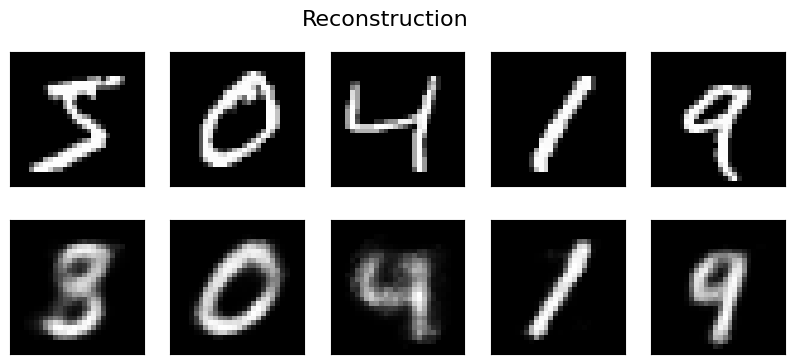

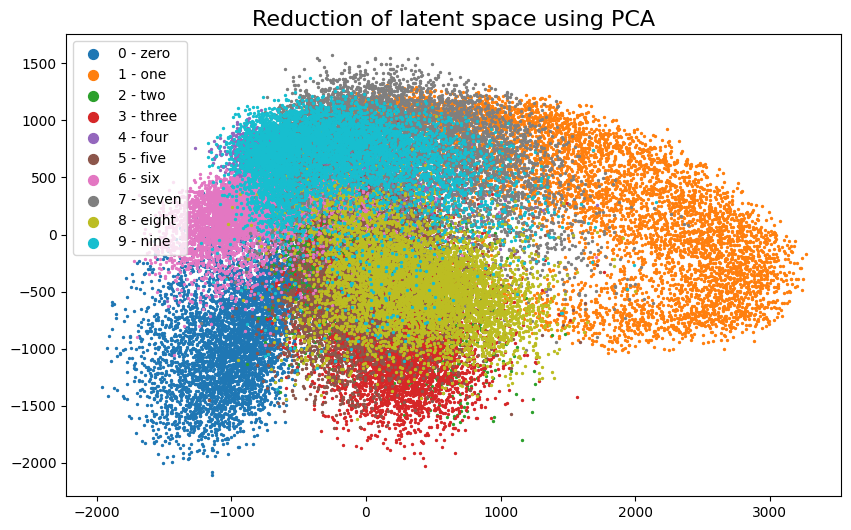

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


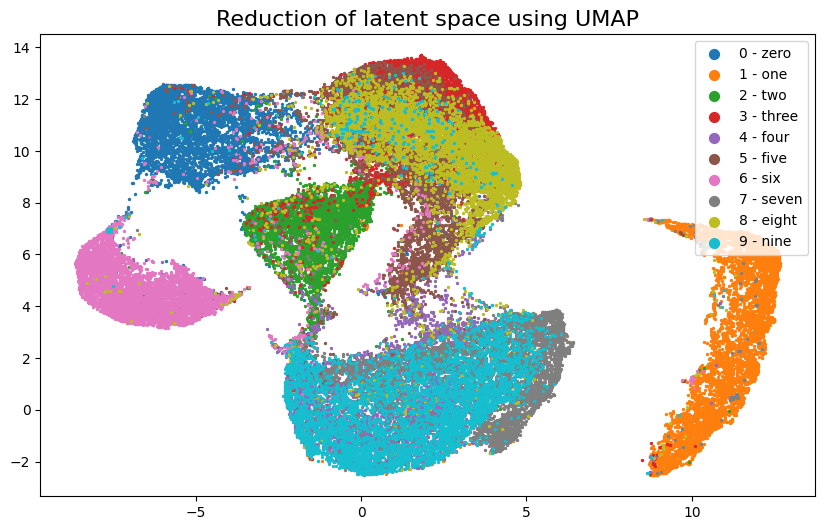

Epoch: 1  |  train loss: 0.0287
Epoch: 2  |  train loss: 0.0244
Epoch: 3  |  train loss: 0.0214
Epoch: 4  |  train loss: 0.0198
Epoch: 5  |  train loss: 0.0186
Epoch: 6  |  train loss: 0.0180
Epoch: 7  |  train loss: 0.0174
Epoch: 8  |  train loss: 0.0170
Epoch: 9  |  train loss: 0.0167
Epoch: 10  |  train loss: 0.0165


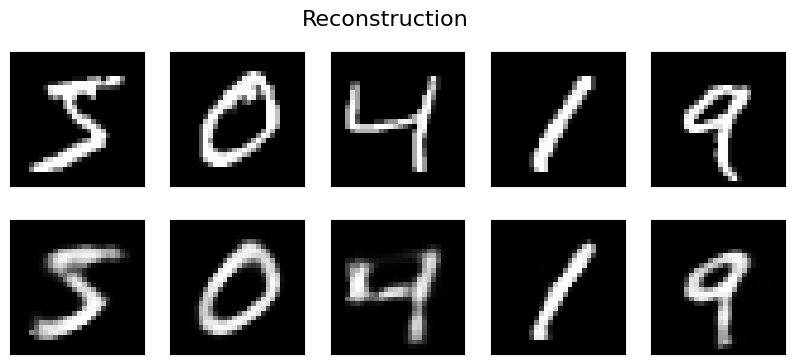

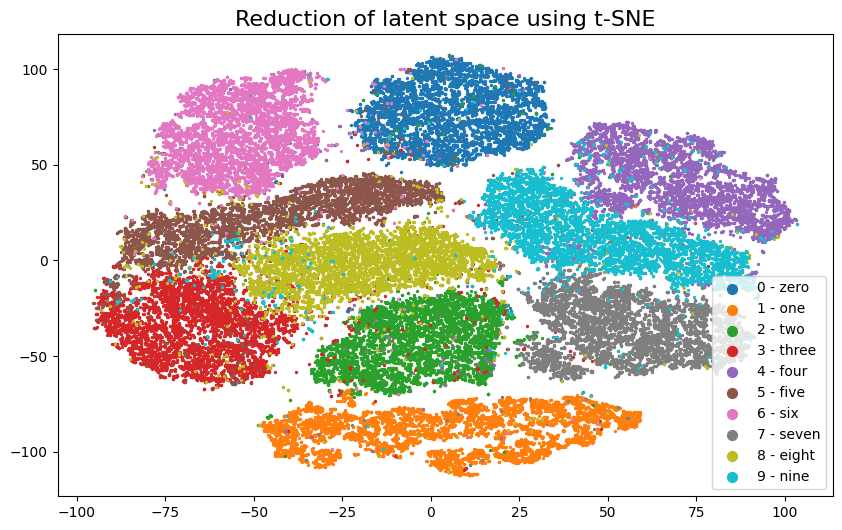

Epoch: 11  |  train loss: 0.0162
Epoch: 12  |  train loss: 0.0160
Epoch: 13  |  train loss: 0.0158
Epoch: 14  |  train loss: 0.0157
Epoch: 15  |  train loss: 0.0156
Epoch: 16  |  train loss: 0.0155
Epoch: 17  |  train loss: 0.0153
Epoch: 18  |  train loss: 0.0153
Epoch: 19  |  train loss: 0.0151
Epoch: 20  |  train loss: 0.0151


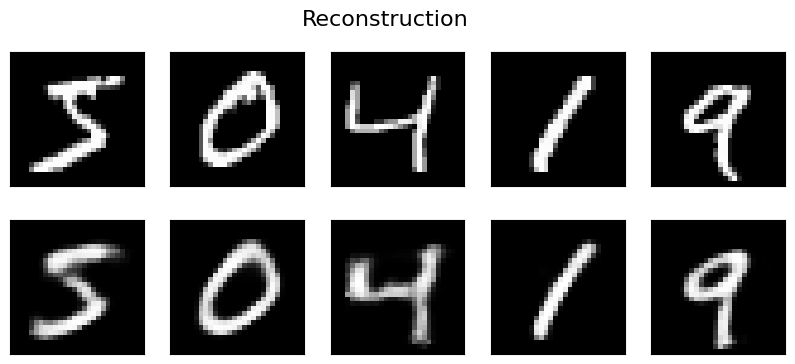

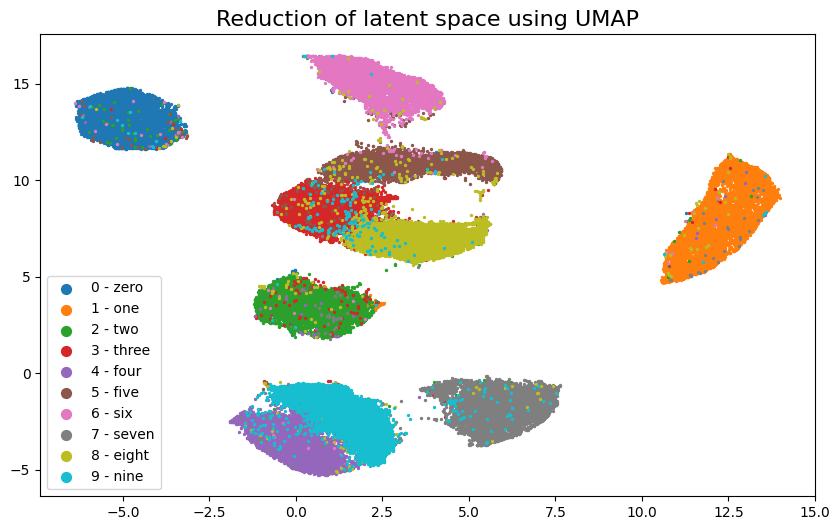

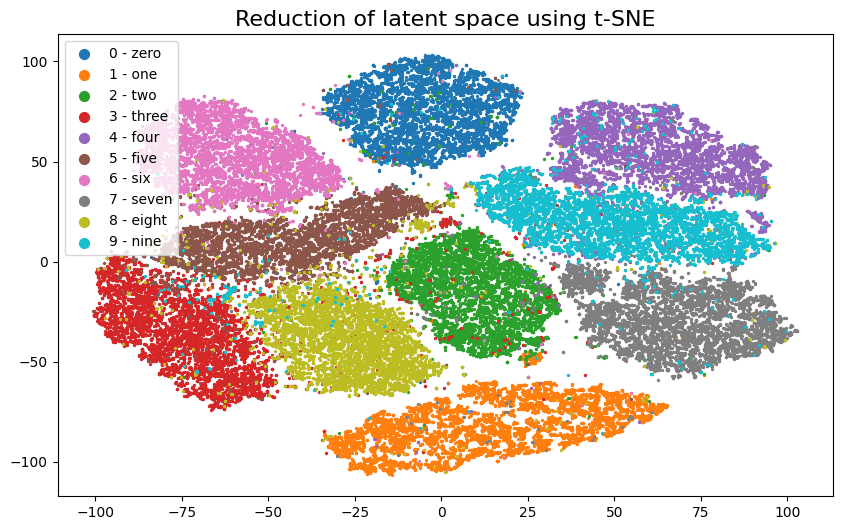

Epoch: 21  |  train loss: 0.0150
Epoch: 22  |  train loss: 0.0150
Epoch: 23  |  train loss: 0.0149
Epoch: 24  |  train loss: 0.0148


In [5]:
# Hyper Parameters
epochs: int = 25
LR: float = 5e-3  # learning rate

# prepare original data for plotting

autoencoder = AutoEncoder(latent_dim=10).to(device)

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=LR)
rec_loss_fn = torch.nn.MSELoss()

for epoch in range(epochs):
    epoch_losses = []  # For logging purposes
    for step, (x, y) in enumerate(train_loader):
        x = x.to(device)
        encoded, decoded = autoencoder(x)
        loss_val = rec_loss_fn(decoded, x)  # calculate loss
        optimizer.zero_grad()  # clear gradients for this training step
        loss_val.backward()  # backpropagation, compute gradients
        optimizer.step()  # apply gradients

        epoch_losses.append(loss_val.item())

    print(f"Epoch: {epoch}  |  train loss: {np.mean(epoch_losses):.4f}")

    if epoch % 10 == 0:
        plot_dataset(train_data, autoencoder)
        plot_pca(train_data, autoencoder)
        plot_umap(train_data, autoencoder)
        plot_tsne(train_data, autoencoder)

## Część 1: Uczenie częściowo nadzorowane (semi-supervised learning)

W praktyce zbudowanie w pełni nadzorowanego zbioru danych często jest kosztowne. Jeżeli chcielibyśmy uczyć się klasyfikacji obrazków naturalnych, to zdobycie dużych zbiorów danych nie jest trudne (możemy je zescrapować z internetu), natomiast zdobycie do nich etykiet wymagałoby czasu człowieka, który zidentyfikowałby, co się znajduje na poszczególnych obrazkach. W niektórych przypadkach etykietowanie jest jeszcze bardziej kosztowne - w zagadnieniu segmentacji, gdzie chcemy każdemu pikselowi w obrazku przypisać jedną klasę, zapisanie etykiety dla jednego obrazka może zająć ekspertowi kilka godzin.

Problem liczby etykiet i ich jakości jest w praktyce bardzo istotny. Dlatego też w praktyce chcielibyśmy mieć metody głębokiego uczenia, które potrafią wykorzystać dane, dla których nie mamy etykiet. W poniższym przykładzie zbudujemy prosty model częściowo nadzorowany z wykorzystaniem autoenkodera.


## Zadanie 2. Uczenie częściowo nadzorowane (3 pkt.)

Załóżmy, że z 60.000 przykładów zbiorze MNIST tylko 100 przykładów ma podaną etykietę, a dla pozostałych 59.900 nie mamy etykiety - tym samym mamy problem uczenia częściowo nadzorowanego. Nasze 100 przykładów z etykietami zdefiniowane są w zmiennej `labeled_data`.

1. Zaimplementuj i wytrenuj sieć neuronową (klasyfikator), która uczy się wyłącznie bezpośrednio na 100 podanych przykładach. Po **wytrenowaniu wypisz accuracy na zbiorze testowym, jaki udało Ci się uzyskać**. Sieć powinna być względnie mała (max 4 warstwy, max 128 neuronów w warstwie). Zapisz wynik.
2. Zaimplementuj i wytrenuj sieć neuronową (klasyfikator) o podobnej architekturze co w poprzednim punkcie, również na datasecie 100 przykładów, ale tym razem niech wejściem do sieci będzie ukryta reprezentacja $y = \mathcal{E}x$ stworzona przez autoenkoder wytrenowany w Zadaniu 1. Zapisz wynik.
3. Porównaj wyniki obu modeli. Wskaż, który nauczył się lepiej i podaj hipotezę dlaczego.


In [6]:
labeled_data = Subset(train_data, range(100))
labeled_loader = torch.utils.data.DataLoader(dataset=labeled_data, batch_size=32, shuffle=True)

test_data = MNIST(
    root=".", train=False, transform=transforms, download=True
)  # change to false if you already have the data
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=5000, shuffle=True)

## Zad 1
Zaimplementuj i wytrenuj sieć neuronową (klasyfikator), która uczy się wyłącznie bezpośrednio na 100 podanych przykładach. Po **wytrenowaniu wypisz accuracy na zbiorze testowym, jaki udało Ci się uzyskać**. Sieć powinna być względnie mała (max 4 warstwy, max 128 neuronów w warstwie). Zapisz wynik.

In [7]:
def train(model: nn.Module,
          train_loader: torch.utils.data.DataLoader,
          loss_fn: nn.Module,
          optimizer: torch.optim.Optimizer) -> float:
    running_loss = 0.
    model.train()

    for i, (X, y) in enumerate(train_loader, 1):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"\tAverage Loss {avg_loss:.4f}")
    return avg_loss

In [8]:
def test(model: nn.Module,
         test_loader: torch.utils.data.DataLoader,
         loss_fn: nn.Module) -> Tuple[float, float]:
    model.eval()
    running_loss = 0.
    correct = 0

    with torch.inference_mode():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            running_loss += loss.item()
            _, predicted = torch.max(y_pred, 1)
            correct += (predicted == y).sum().item()

    avg_loss = running_loss / len(test_loader)
    accuracy = correct / len(test_loader.dataset)
    print(f"\tAverage Loss: {avg_loss:.4f}")
    print(f"\tAccuracy: {accuracy:.2%}")
    return avg_loss, accuracy

In [9]:
### Tutaj zaimplementuj i wytrenuj model baseline'owy

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(nn.Linear(28 * 28, 128),
                                   nn.ReLU(),
                                   nn.Linear(128, 128),
                                   nn.ReLU(),
                                   nn.Linear(128, 10))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)

In [10]:
classifier = Classifier().to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-3)

In [11]:
EPOCHS = 20

In [12]:
baseline_train_losses = []
baseline_test_losses = []
baseline_test_accs = []


for epoch in range(EPOCHS):
    print(f"Epoch: {epoch}")
    print("\tTraining:")
    train_loss = train(classifier, labeled_loader, loss_fn, optimizer)
    baseline_train_losses.append(train_loss)
    print("\tTesting:")
    test_loss, test_acc = test(classifier, test_loader, loss_fn)
    baseline_test_losses.append(test_loss)
    baseline_test_accs.append(test_acc)
print(f"Final accuracy: {test_acc:.2%}")

Epoch: 0
	Training:
	Average Loss 2.2651
	Testing:
	Average Loss: 2.2499
	Accuracy: 13.10%
Epoch: 1
	Training:
	Average Loss 2.1785
	Testing:
	Average Loss: 2.1823
	Accuracy: 21.29%
Epoch: 2
	Training:
	Average Loss 2.0675
	Testing:
	Average Loss: 2.0957
	Accuracy: 30.87%
Epoch: 3
	Training:
	Average Loss 1.8982
	Testing:
	Average Loss: 1.9959
	Accuracy: 39.03%
Epoch: 4
	Training:
	Average Loss 1.8477
	Testing:
	Average Loss: 1.8834
	Accuracy: 47.17%
Epoch: 5
	Training:
	Average Loss 1.4802
	Testing:
	Average Loss: 1.7560
	Accuracy: 53.56%
Epoch: 6
	Training:
	Average Loss 1.4511
	Testing:
	Average Loss: 1.6429
	Accuracy: 53.01%
Epoch: 7
	Training:
	Average Loss 1.0423
	Testing:
	Average Loss: 1.5285
	Accuracy: 57.11%
Epoch: 8
	Training:
	Average Loss 0.9217
	Testing:
	Average Loss: 1.4348
	Accuracy: 60.12%
Epoch: 9
	Training:
	Average Loss 0.8805
	Testing:
	Average Loss: 1.3340
	Accuracy: 63.26%
Epoch: 10
	Training:
	Average Loss 0.6358
	Testing:
	Average Loss: 1.2404
	Accuracy: 63.15

## Zad 2
Zaimplementuj i wytrenuj sieć neuronową (klasyfikator) o podobnej architekturze co w poprzednim punkcie, również na datasecie 100 przykładów, ale tym razem niech wejściem do sieci będzie ukryta reprezentacja $y = \mathcal{E}x$ stworzona przez autoenkoder wytrenowany w Zadaniu 1. Zapisz wynik.


In [13]:
class ClassifierWithAE(nn.Module):
    def __init__(self, autoencoder: AutoEncoder):
        super().__init__()
        self.autoencoder = autoencoder
        self.classifier = nn.Sequential(nn.Linear(10, 128),
                                        nn.ReLU(),
                                        nn.Linear(128, 128),
                                        nn.ReLU(),
                                        nn.Linear(128, 10))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.autoencoder.encode(x)
        return self.classifier(x)

In [14]:
classifier_with_ae = ClassifierWithAE(autoencoder).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classifier_with_ae.parameters(), lr=1e-3)

In [15]:
ae_train_losses = []
ae_test_losses = []
ae_test_accs = []

for epoch in range(EPOCHS):
    print(f"Epoch: {epoch}")
    print("\tTraining:")
    train_loss = train(classifier_with_ae, labeled_loader, loss_fn, optimizer)
    ae_train_losses.append(train_loss)
    print("\tTesting:")
    test_loss, test_acc = test(classifier_with_ae, test_loader, loss_fn)
    ae_test_losses.append(test_loss)
    ae_test_accs.append(test_acc)
print(f"Final accuracy: {test_acc:.2%}")

Epoch: 0
	Training:
	Average Loss 2.2599
	Testing:
	Average Loss: 2.1282
	Accuracy: 44.17%
Epoch: 1
	Training:
	Average Loss 1.9822
	Testing:
	Average Loss: 1.9892
	Accuracy: 46.90%
Epoch: 2
	Training:
	Average Loss 1.7982
	Testing:
	Average Loss: 1.8379
	Accuracy: 46.43%
Epoch: 3
	Training:
	Average Loss 1.5264
	Testing:
	Average Loss: 1.6684
	Accuracy: 53.43%
Epoch: 4
	Training:
	Average Loss 1.3157
	Testing:
	Average Loss: 1.4754
	Accuracy: 61.06%
Epoch: 5
	Training:
	Average Loss 0.9726
	Testing:
	Average Loss: 1.2698
	Accuracy: 67.36%
Epoch: 6
	Training:
	Average Loss 0.8704
	Testing:
	Average Loss: 1.0696
	Accuracy: 71.36%
Epoch: 7
	Training:
	Average Loss 0.6564
	Testing:
	Average Loss: 0.9192
	Accuracy: 72.94%
Epoch: 8
	Training:
	Average Loss 0.4449
	Testing:
	Average Loss: 0.8107
	Accuracy: 75.50%
Epoch: 9
	Training:
	Average Loss 0.2650
	Testing:
	Average Loss: 0.7988
	Accuracy: 74.39%
Epoch: 10
	Training:
	Average Loss 0.2997
	Testing:
	Average Loss: 0.8131
	Accuracy: 73.79

## Zad 3
Porównaj wyniki obu modeli. Wskaż, który nauczył się lepiej i podaj hipotezę dlaczego.

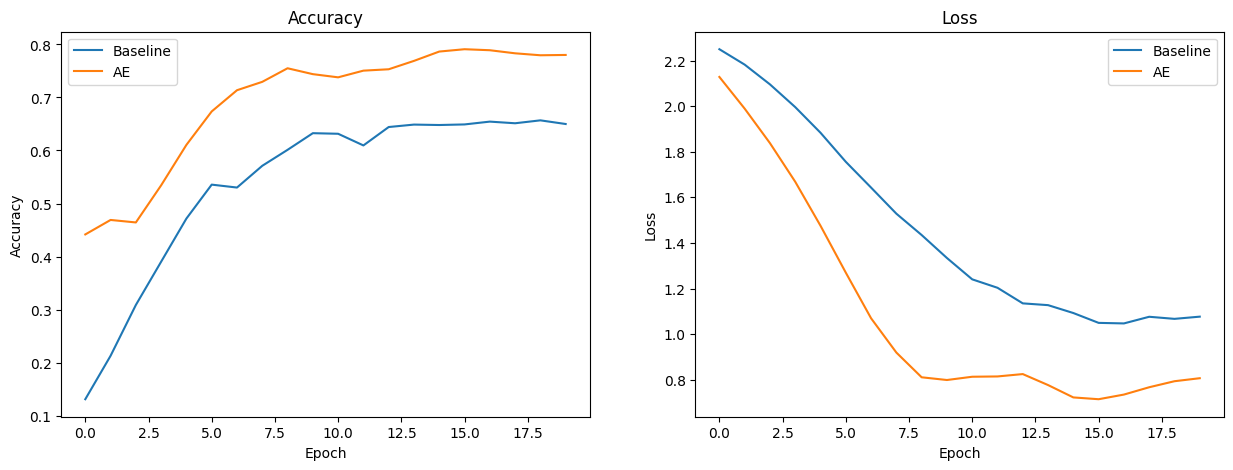

In [16]:
# Compare results
plt.subplots(1, 2, figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(baseline_test_accs, label="Baseline")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(ae_test_accs, label="AE")
plt.title("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(baseline_test_losses, label="Baseline")
plt.plot(ae_test_losses, label="AE")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss")
plt.legend()
plt.show()

### Dlaczego model z autoenkoderem działa lepiej?

Model z autoenkoderem działa lepiej, ponieważ uczy się reprezentacji danych, która jest bardziej użyteczna dla klasyfikatora. W przypadku modelu baseline'owego, sieć musi sama nauczyć się reprezentacji danych, co jest trudniejsze i wymaga więcej danych. W przypadku modelu z autoenkoderem, sieć korzysta z reprezentacji danych, która jest już nauczona i zadana przez autoenkoder, co pozwala na lepsze wyniki przy mniejszej ilości danych. Autoenkoder działa w tym przypadku jak 'feature extractor', który dostarcza klasyfikatorowi bardziej użyteczne informacje o danych i redukuje szum.

## Dygresja: Inne zagadnienia uczenia ze słabym nadzorem
Podany powyżej przykład jest bardzo prostym podejściem do problemu uczenia danych ze słabym nadzorem. Dla zainteresowanych trochę więcej materiałów:

* [Praca przeglądowa o problemie słabego nadzoru](https://academic.oup.com/nsr/article-pdf/5/1/44/31567770/nwx106.pdf)
* [Pseudo-labeling do uczenia częściowo nazdorowanego](https://github.com/emintham/Papers/blob/master/Lee-%20Pseudo-Label:%20The%20Simple%20and%20Efficient%20Semi-Supervised%20Learning%20Method%20for%20Deep%20Neural%20Networks.pdf) - W tym podejściu do uczenia częściowo nadzorowanego trenujemy model na poetykietowanych danych, używamy jego predykcji żeby poetykietować resztę danych i uczymy model z takimi (narzuconymi przez siebie) etykietami. Wbrew intuicji to podejście dziala całkiem dobrze.
* [Przegląd metod self-supervision](https://lilianweng.github.io/lil-log/2019/11/10/self-supervised-learning.html) - Czy możemy się uczyć z danych na podstawie łatwych do otrzymania etykiet (np. o ile stopni zdjęcie zostało obrócone)?
* [Przegląd metod kontrastywnych](https://arxiv.org/abs/2011.00362) - Czy możemy się uczyć reprezentacji na podstawie szukania podobieństw między przykładami?

# Część 2: Modele generatywne

Interesującym zastosowaniem sieci neuronowych jest generowanie nowych przykładów ze zbioru treningowego, np. [generowanie nowych twarzy](https://thispersondoesnotexist.com/) albo [generowanie tekstu](https://transformer.huggingface.co/doc/gpt2-large). Na dzisiejszych zajęciach spróbujemy zbudować prosty model generatywny oparty o autoenkoder.

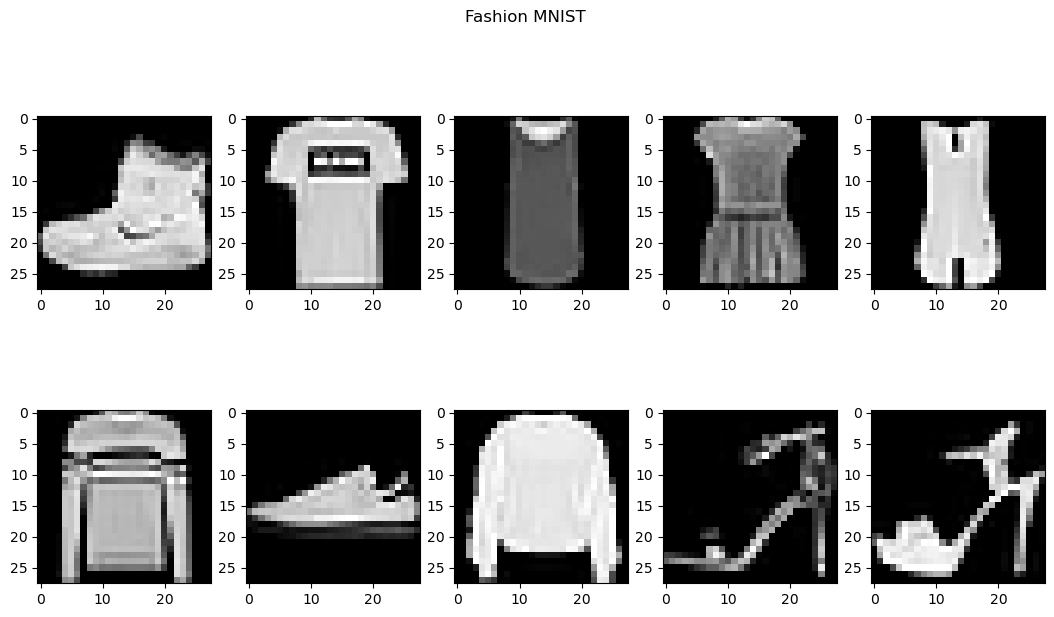

In [5]:
# FashionMNIST dataset
transforms = Compose([ToTensor(), Lambda(lambda x: x.flatten())])
train_data = FashionMNIST(root=".", train=True, transform=transforms, download=True)

batch_size = 256
# Data Loader for easy mini-batch return in training, the image batch shape will be (50, 1, 28, 28)
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

_, axes = plt.subplots(2, 5, figsize=(13, 7))
for im, ax in zip(train_data.data[:10], axes.reshape(-1)):
    ax.imshow(im, cmap="gray")
plt.suptitle("Fashion MNIST")
plt.show()


## Zadanie 3: WAE-MMD (3 pkt.)
W ramach zadania należy:
1. Zaimplementować architekturę autoenkodera (enkoder + dekoder), podobną do tej zaprezentowanej w Zadaniu 1. Jako że dataset FMNIST jest trudniejszy, to architektura też powinna być istotnie większa (np. 50 wymiarów przestrzeni ukrytej).
2. Zaimplementować pętlę uczenia WAE, w której minimalizujemy koszt $\mathcal{L}_{WAE-MMD}$.
3. Dostosować hiperparametry (learning rate, liczba epok, $C$, $\sigma$, etc.), tak żeby rekonstrukcja i generowane sample wyglądały na poziomie porównywalnym do tych pokazanych poniżej (albo lepiej). Zacznij od $C=1$, $\sigma = 2D$, gdzie $D$ to wymiar przestrzeni ukrytej.

W razie potrzeby można wspomóc się materiałami z wykładu, [oryginalną pracą o autoenkoderze Wassersteina](https://arxiv.org/abs/1711.01558) (interesuje nas zwłaszcza strona piąta, Algorytm 2 WAE-MMD) oraz [oficjalnie dostępną implementacją](https://github.com/tolstikhin/wae).



In [6]:
def plot_samples(model):
    # Important part - sampling from normal distribution and passing the results through the decoder.
    sampled_z = torch.randn(20, model.latent_dim).cuda()
    generated = model.decode(sampled_z)

    # Plotting the results
    generated = generated.cpu().detach().numpy()
    _, axes = plt.subplots(2, 10, figsize=(15, 4))
    for gen_im, ax in zip(generated, axes.reshape(-1)):
        ax.imshow(gen_im.reshape(28, 28), cmap="gray")
    plt.suptitle("Generated samples")
    plt.show()


In [22]:
import torch.nn as nn

class WAEMMD(nn.Module):
    def __init__(self, latent_dim: int):
        super().__init__()
        self.latent_dim = latent_dim
        self.encoder = nn.Sequential(nn.Linear(784, 256),
                                     nn.ReLU(),
                                     nn.BatchNorm1d(256),
                                     nn.Linear(256, 256),
                                     nn.ReLU(),
                                     nn.BatchNorm1d(256),
                                     nn.Linear(256, 128),
                                     nn.ReLU(),
                                     nn.BatchNorm1d(128),
                                     nn.Linear(128, self.latent_dim))
        self.decoder = nn.Sequential(nn.Linear(self.latent_dim, 128),
                                     nn.ReLU(),
                                     nn.BatchNorm1d(128),
                                     nn.Linear(128, 256),
                                     nn.ReLU(),
                                     nn.BatchNorm1d(256),
                                     nn.Linear(256, 256),
                                     nn.ReLU(),
                                     nn.BatchNorm1d(256),
                                     nn.Linear(256, 784),
                                     nn.Sigmoid())

    def encode(self, x: torch.Tensor):
        return self.encoder(x)

    def decode(self, encoded: torch.Tensor):
        return self.decoder(encoded)

    def forward(self, x: torch.Tensor):
        encoded = self.encode(x)
        decoded = self.decode(encoded)
        return encoded, decoded

    @staticmethod
    def gaussian_kernel(x, y, sigma):
        beta = 1 / (2 * sigma ** 2)
        dist = torch.cdist(x, y, p=2) ** 2
        return torch.exp(-beta * dist)

    def mmd_loss(self, z_real: torch.Tensor, z_fake: torch.Tensor, sigma: float):
        k_zz = WAEMMD.gaussian_kernel(z_real, z_real, sigma)
        k_z_tilde_z_tilde = WAEMMD.gaussian_kernel(z_fake, z_fake, sigma)
        k_zz_tilde = WAEMMD.gaussian_kernel(z_real, z_fake, sigma)

        mmd = k_zz.mean() + k_z_tilde_z_tilde.mean() - 2 * k_zz_tilde.mean()
        return mmd


Epoch 1/100, Total Loss: 7.6492, Recon Loss: 7.6492, MMD Loss: 1.1645
Epoch 2/100, Total Loss: 4.6808, Recon Loss: 4.6697, MMD Loss: 0.1111
Epoch 3/100, Total Loss: 4.1114, Recon Loss: 4.1060, MMD Loss: 0.0269
Epoch 4/100, Total Loss: 3.7825, Recon Loss: 3.7750, MMD Loss: 0.0251
Epoch 5/100, Total Loss: 3.5757, Recon Loss: 3.5653, MMD Loss: 0.0260
Epoch 6/100, Total Loss: 3.4212, Recon Loss: 3.4078, MMD Loss: 0.0268
Epoch 7/100, Total Loss: 3.2969, Recon Loss: 3.2808, MMD Loss: 0.0268
Epoch 8/100, Total Loss: 3.1994, Recon Loss: 3.1807, MMD Loss: 0.0266
Epoch 9/100, Total Loss: 3.1183, Recon Loss: 3.0968, MMD Loss: 0.0270
Epoch 10/100, Total Loss: 3.0592, Recon Loss: 3.0349, MMD Loss: 0.0271
Visualizing results at epoch 10...


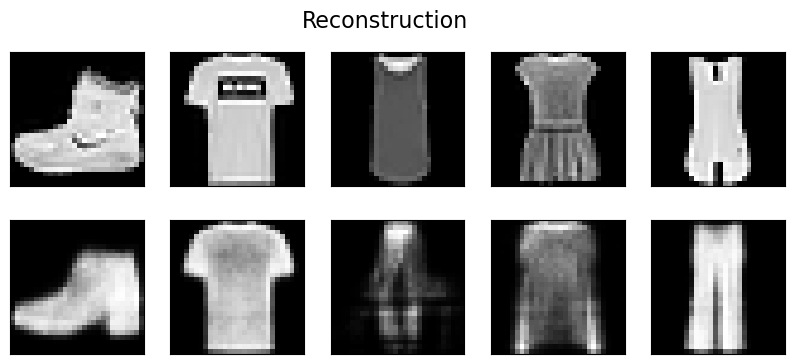

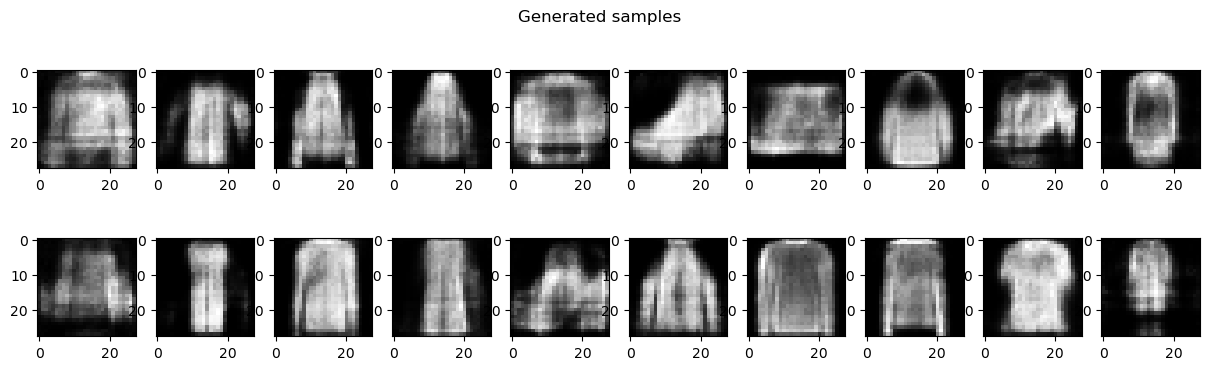

Epoch 11/100, Total Loss: 3.0063, Recon Loss: 2.9791, MMD Loss: 0.0272
Epoch 12/100, Total Loss: 2.9601, Recon Loss: 2.9302, MMD Loss: 0.0272
Epoch 13/100, Total Loss: 2.8991, Recon Loss: 2.8672, MMD Loss: 0.0266
Epoch 14/100, Total Loss: 2.8704, Recon Loss: 2.8347, MMD Loss: 0.0274
Epoch 15/100, Total Loss: 2.8191, Recon Loss: 2.7815, MMD Loss: 0.0269
Epoch 16/100, Total Loss: 2.7858, Recon Loss: 2.7455, MMD Loss: 0.0268
Epoch 17/100, Total Loss: 2.7608, Recon Loss: 2.7182, MMD Loss: 0.0266
Epoch 18/100, Total Loss: 2.7308, Recon Loss: 2.6842, MMD Loss: 0.0274
Epoch 19/100, Total Loss: 2.6982, Recon Loss: 2.6506, MMD Loss: 0.0264
Epoch 20/100, Total Loss: 2.6672, Recon Loss: 2.6172, MMD Loss: 0.0263
Visualizing results at epoch 20...


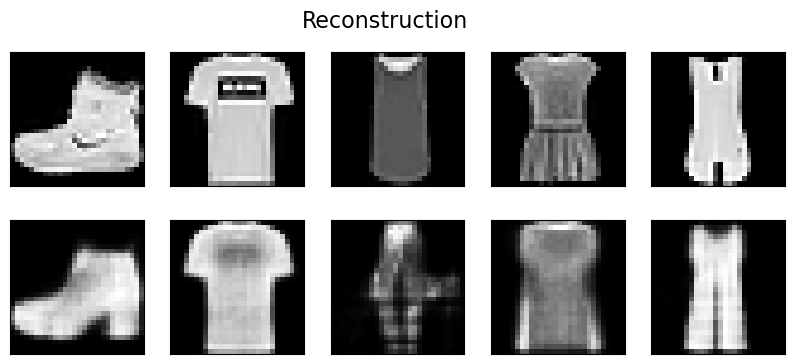

Epoch 21/100, Total Loss: 2.6513, Recon Loss: 2.5978, MMD Loss: 0.0268
Epoch 22/100, Total Loss: 2.6275, Recon Loss: 2.5696, MMD Loss: 0.0276
Epoch 23/100, Total Loss: 2.6018, Recon Loss: 2.5448, MMD Loss: 0.0259
Epoch 24/100, Total Loss: 2.5889, Recon Loss: 2.5280, MMD Loss: 0.0265
Epoch 25/100, Total Loss: 2.5675, Recon Loss: 2.5044, MMD Loss: 0.0263
Epoch 26/100, Total Loss: 2.5528, Recon Loss: 2.4865, MMD Loss: 0.0265
Epoch 27/100, Total Loss: 2.5418, Recon Loss: 2.4742, MMD Loss: 0.0260
Epoch 28/100, Total Loss: 2.5241, Recon Loss: 2.4545, MMD Loss: 0.0258
Epoch 29/100, Total Loss: 2.5059, Recon Loss: 2.4331, MMD Loss: 0.0260
Epoch 30/100, Total Loss: 2.4899, Recon Loss: 2.4141, MMD Loss: 0.0261
Visualizing results at epoch 30...


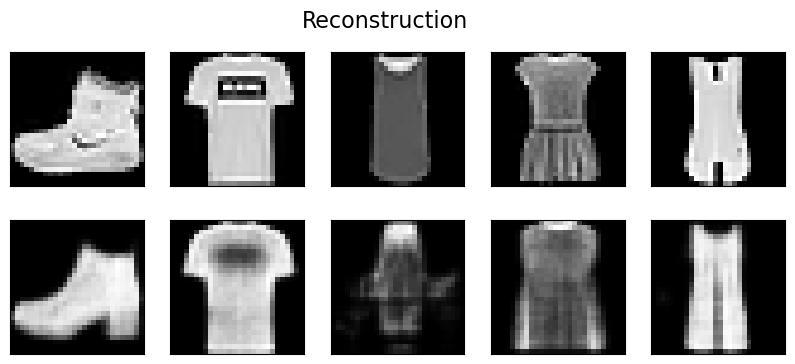

Epoch 31/100, Total Loss: 2.4826, Recon Loss: 2.4027, MMD Loss: 0.0266
Epoch 32/100, Total Loss: 2.4689, Recon Loss: 2.3899, MMD Loss: 0.0255
Epoch 33/100, Total Loss: 2.4569, Recon Loss: 2.3755, MMD Loss: 0.0255
Epoch 34/100, Total Loss: 2.4494, Recon Loss: 2.3633, MMD Loss: 0.0261
Epoch 35/100, Total Loss: 2.4320, Recon Loss: 2.3460, MMD Loss: 0.0253
Epoch 36/100, Total Loss: 2.4279, Recon Loss: 2.3391, MMD Loss: 0.0254
Epoch 37/100, Total Loss: 2.4210, Recon Loss: 2.3294, MMD Loss: 0.0254
Epoch 38/100, Total Loss: 2.4119, Recon Loss: 2.3159, MMD Loss: 0.0259
Epoch 39/100, Total Loss: 2.3987, Recon Loss: 2.2996, MMD Loss: 0.0261
Epoch 40/100, Total Loss: 2.3892, Recon Loss: 2.2910, MMD Loss: 0.0252
Visualizing results at epoch 40...


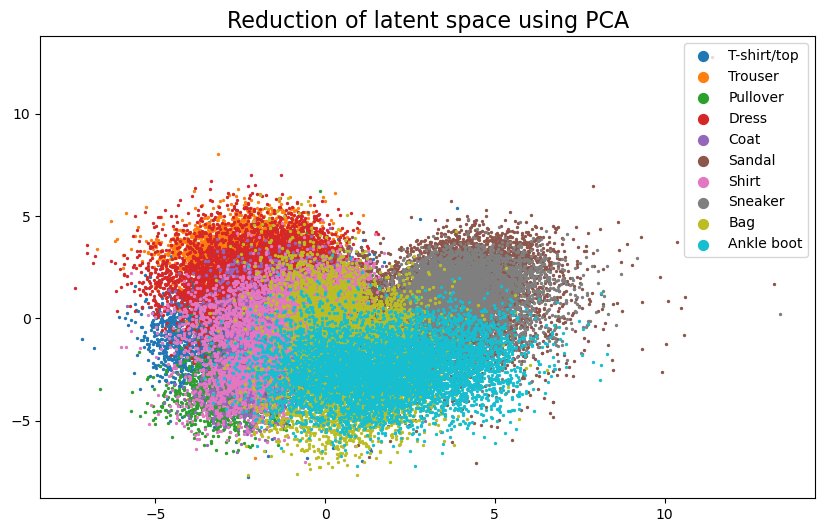

Epoch 41/100, Total Loss: 2.3826, Recon Loss: 2.2809, MMD Loss: 0.0254
Epoch 42/100, Total Loss: 2.3805, Recon Loss: 2.2783, MMD Loss: 0.0249
Epoch 43/100, Total Loss: 2.3670, Recon Loss: 2.2632, MMD Loss: 0.0247
Epoch 44/100, Total Loss: 2.3666, Recon Loss: 2.2596, MMD Loss: 0.0249
Epoch 45/100, Total Loss: 2.3590, Recon Loss: 2.2514, MMD Loss: 0.0244
Epoch 46/100, Total Loss: 2.3477, Recon Loss: 2.2362, MMD Loss: 0.0248
Epoch 47/100, Total Loss: 2.3427, Recon Loss: 2.2281, MMD Loss: 0.0249
Epoch 48/100, Total Loss: 2.3397, Recon Loss: 2.2253, MMD Loss: 0.0243
Epoch 49/100, Total Loss: 2.3335, Recon Loss: 2.2194, MMD Loss: 0.0238
Epoch 50/100, Total Loss: 2.3295, Recon Loss: 2.2102, MMD Loss: 0.0243
Visualizing results at epoch 50...


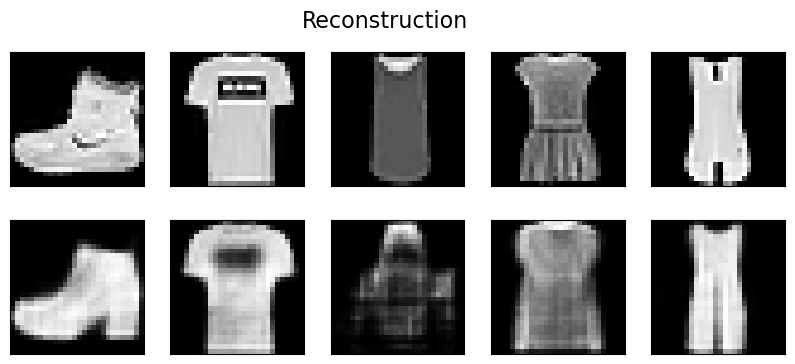

Epoch 51/100, Total Loss: 2.3206, Recon Loss: 2.1976, MMD Loss: 0.0246
Epoch 52/100, Total Loss: 2.3222, Recon Loss: 2.2011, MMD Loss: 0.0237
Epoch 53/100, Total Loss: 2.3171, Recon Loss: 2.1923, MMD Loss: 0.0240
Epoch 54/100, Total Loss: 2.3059, Recon Loss: 2.1781, MMD Loss: 0.0241
Epoch 55/100, Total Loss: 2.3009, Recon Loss: 2.1745, MMD Loss: 0.0234
Epoch 56/100, Total Loss: 2.3020, Recon Loss: 2.1698, MMD Loss: 0.0240
Epoch 57/100, Total Loss: 2.2963, Recon Loss: 2.1609, MMD Loss: 0.0242
Epoch 58/100, Total Loss: 2.2941, Recon Loss: 2.1581, MMD Loss: 0.0239
Epoch 59/100, Total Loss: 2.2841, Recon Loss: 2.1468, MMD Loss: 0.0237
Epoch 60/100, Total Loss: 2.2802, Recon Loss: 2.1404, MMD Loss: 0.0237
Visualizing results at epoch 60...


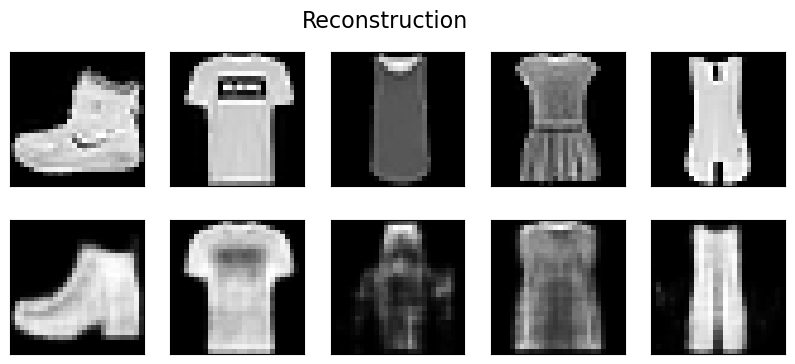

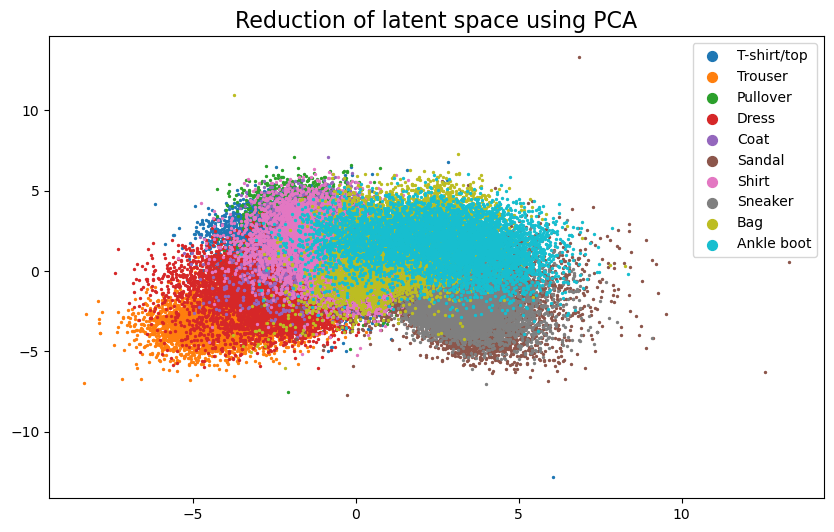

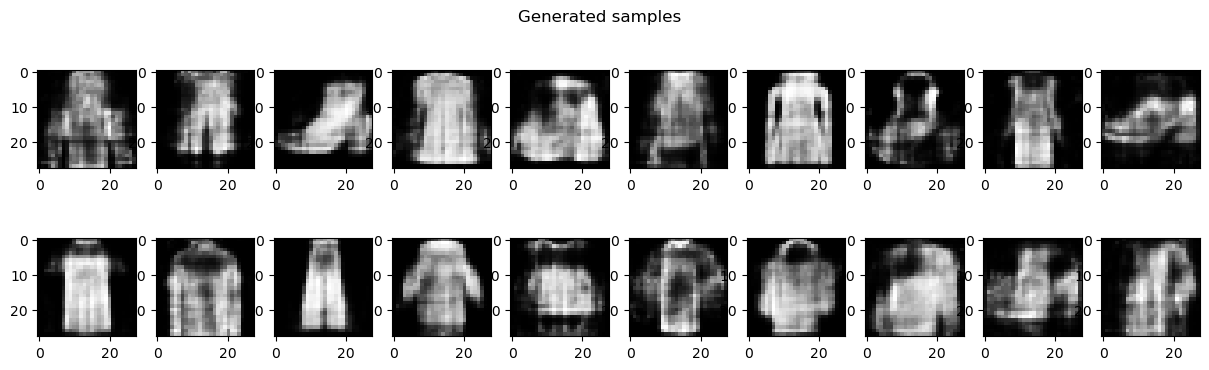

Epoch 61/100, Total Loss: 2.2820, Recon Loss: 2.1383, MMD Loss: 0.0240
Epoch 62/100, Total Loss: 2.2765, Recon Loss: 2.1334, MMD Loss: 0.0235
Epoch 63/100, Total Loss: 2.2702, Recon Loss: 2.1240, MMD Loss: 0.0236
Epoch 64/100, Total Loss: 2.2705, Recon Loss: 2.1216, MMD Loss: 0.0236
Epoch 65/100, Total Loss: 2.2702, Recon Loss: 2.1230, MMD Loss: 0.0230
Epoch 66/100, Total Loss: 2.2680, Recon Loss: 2.1150, MMD Loss: 0.0235
Epoch 67/100, Total Loss: 2.2612, Recon Loss: 2.1059, MMD Loss: 0.0235
Epoch 68/100, Total Loss: 2.2609, Recon Loss: 2.1070, MMD Loss: 0.0230
Epoch 69/100, Total Loss: 2.2542, Recon Loss: 2.0969, MMD Loss: 0.0231
Epoch 70/100, Total Loss: 2.2619, Recon Loss: 2.1010, MMD Loss: 0.0233
Visualizing results at epoch 70...


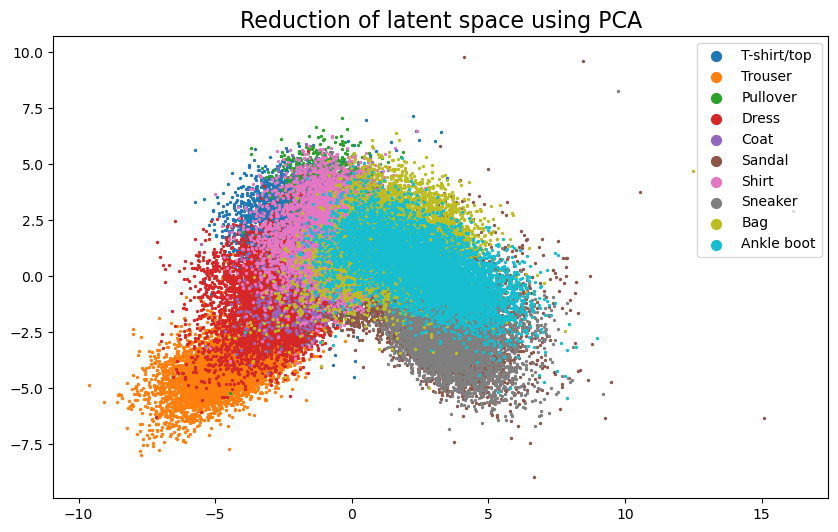

Epoch 71/100, Total Loss: 2.2599, Recon Loss: 2.1000, MMD Loss: 0.0228
Epoch 72/100, Total Loss: 2.2438, Recon Loss: 2.0822, MMD Loss: 0.0228
Epoch 73/100, Total Loss: 2.2465, Recon Loss: 2.0816, MMD Loss: 0.0229
Epoch 74/100, Total Loss: 2.2444, Recon Loss: 2.0776, MMD Loss: 0.0228
Epoch 75/100, Total Loss: 2.2453, Recon Loss: 2.0754, MMD Loss: 0.0230
Epoch 76/100, Total Loss: 2.2433, Recon Loss: 2.0734, MMD Loss: 0.0226
Epoch 77/100, Total Loss: 2.2370, Recon Loss: 2.0642, MMD Loss: 0.0227
Epoch 78/100, Total Loss: 2.2392, Recon Loss: 2.0643, MMD Loss: 0.0227
Epoch 79/100, Total Loss: 2.2307, Recon Loss: 2.0560, MMD Loss: 0.0224
Epoch 80/100, Total Loss: 2.2419, Recon Loss: 2.0639, MMD Loss: 0.0225
Visualizing results at epoch 80...


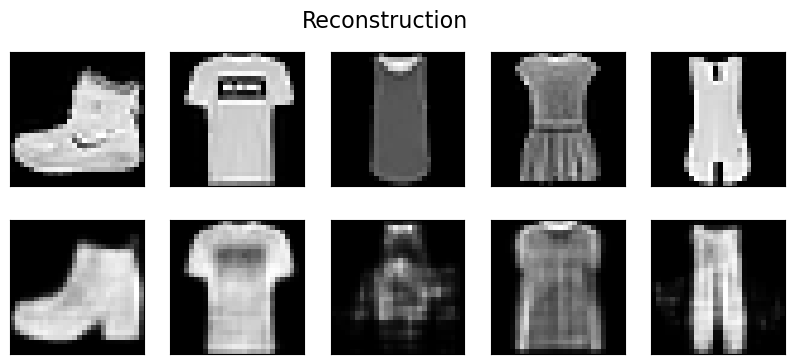

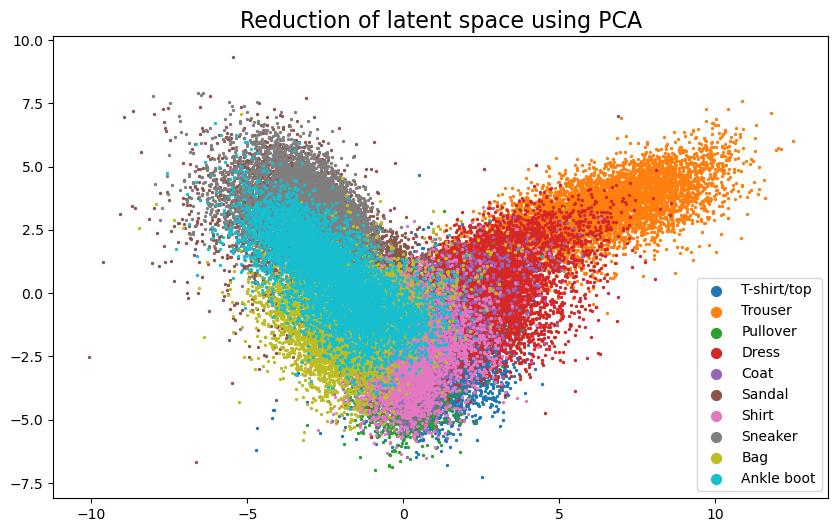

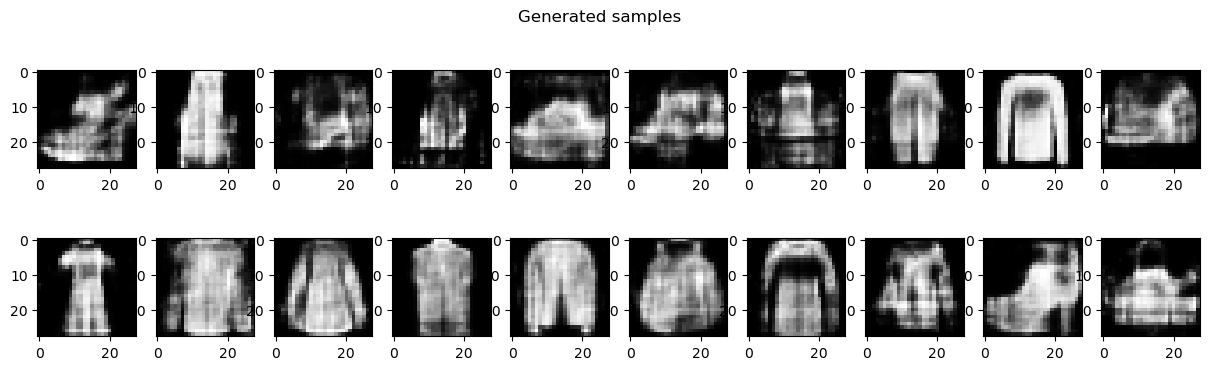

Epoch 81/100, Total Loss: 2.2274, Recon Loss: 2.0507, MMD Loss: 0.0221
Epoch 82/100, Total Loss: 2.2335, Recon Loss: 2.0487, MMD Loss: 0.0228
Epoch 83/100, Total Loss: 2.2279, Recon Loss: 2.0449, MMD Loss: 0.0223
Epoch 84/100, Total Loss: 2.2189, Recon Loss: 2.0384, MMD Loss: 0.0217
Epoch 85/100, Total Loss: 2.2254, Recon Loss: 2.0404, MMD Loss: 0.0220
Epoch 86/100, Total Loss: 2.2252, Recon Loss: 2.0335, MMD Loss: 0.0226
Epoch 87/100, Total Loss: 2.2258, Recon Loss: 2.0345, MMD Loss: 0.0222
Epoch 88/100, Total Loss: 2.2253, Recon Loss: 2.0314, MMD Loss: 0.0223
Epoch 89/100, Total Loss: 2.2222, Recon Loss: 2.0243, MMD Loss: 0.0225
Epoch 90/100, Total Loss: 2.2208, Recon Loss: 2.0256, MMD Loss: 0.0219
Visualizing results at epoch 90...


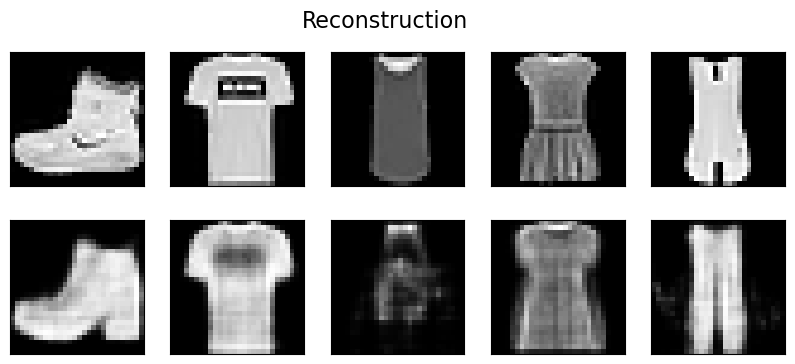

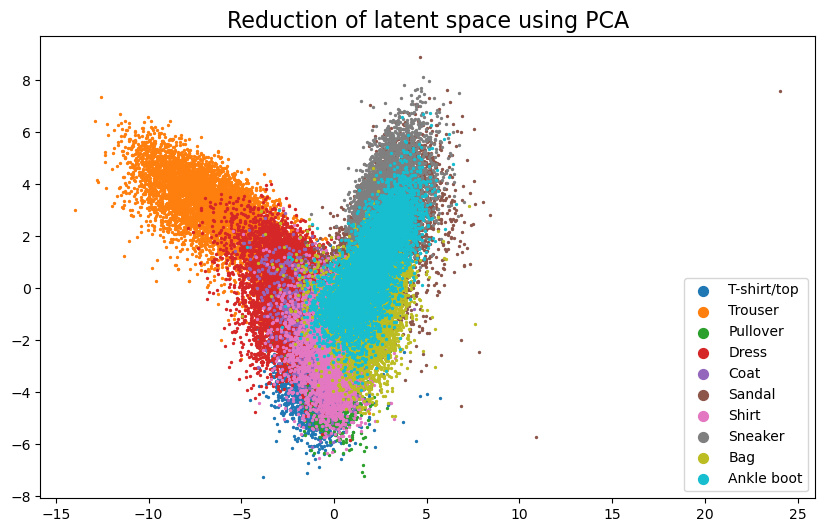

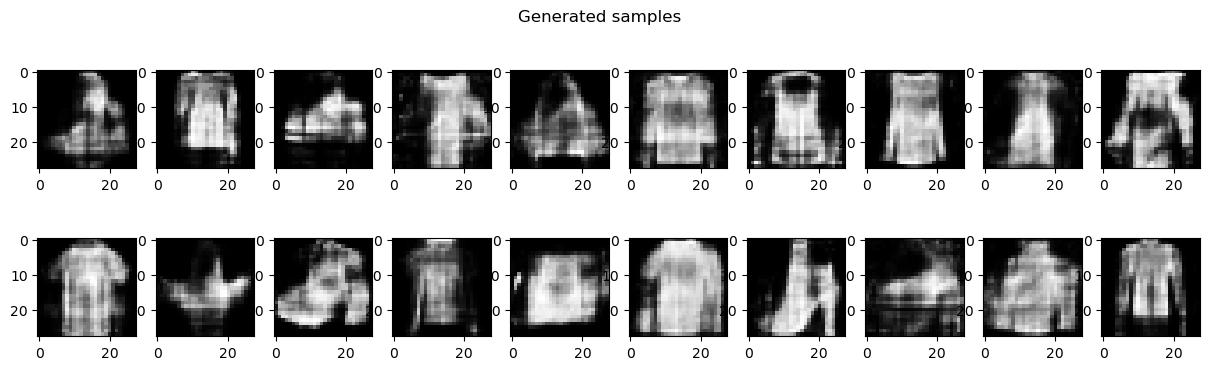

Epoch 91/100, Total Loss: 2.2151, Recon Loss: 2.0209, MMD Loss: 0.0216
Epoch 92/100, Total Loss: 2.2138, Recon Loss: 2.0156, MMD Loss: 0.0218
Epoch 93/100, Total Loss: 2.2115, Recon Loss: 2.0138, MMD Loss: 0.0215
Epoch 94/100, Total Loss: 2.2060, Recon Loss: 2.0061, MMD Loss: 0.0215
Epoch 95/100, Total Loss: 2.2174, Recon Loss: 2.0104, MMD Loss: 0.0220
Epoch 96/100, Total Loss: 2.2168, Recon Loss: 2.0087, MMD Loss: 0.0219
Epoch 97/100, Total Loss: 2.2092, Recon Loss: 2.0026, MMD Loss: 0.0215
Epoch 98/100, Total Loss: 2.2059, Recon Loss: 1.9966, MMD Loss: 0.0216
Epoch 99/100, Total Loss: 2.2059, Recon Loss: 1.9968, MMD Loss: 0.0213
Epoch 100/100, Total Loss: 2.2111, Recon Loss: 1.9925, MMD Loss: 0.0221
Visualizing results at epoch 100...


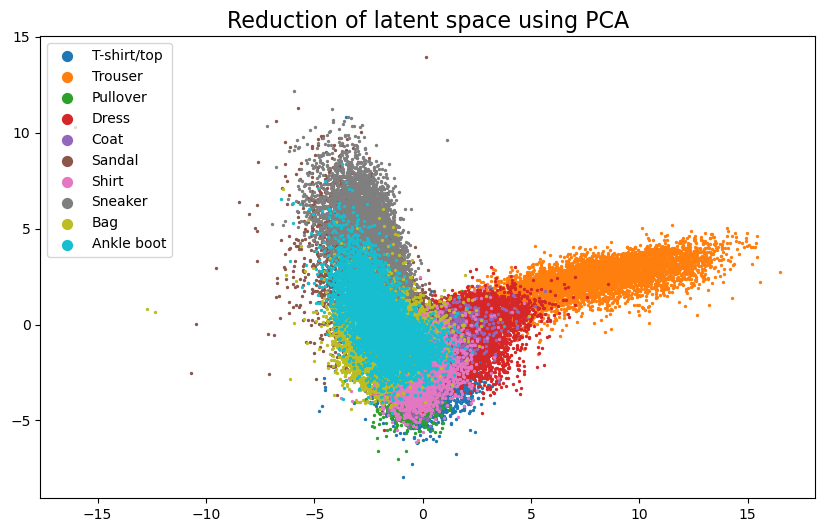

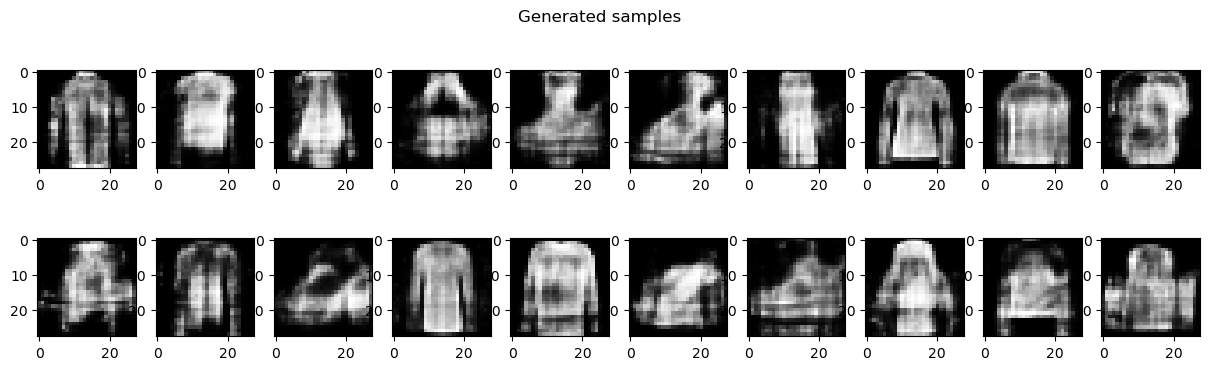

In [10]:
D = 68
C = 10
sigma = D
epochs = 100

wae = WAEMMD(D).to(device)
optimizer = torch.optim.Adam(wae.parameters())
reconstruction_loss_fn = nn.MSELoss()

for epoch in range(epochs):
    wae.train()
    total_loss = 0.0
    total_recon_loss = 0.0
    total_mmd_loss = 0.0
    C = min(10, epoch / 10)  # Stopniowe zwiększanie wagi MMD co epokę

    for x, _ in train_loader:
        x = x.to(device).view(x.size(0), -1)  # Flatten images
        z_fake = wae.encode(x)
        z_real = torch.randn_like(z_fake).to(device)
        x_reconstructed = wae.decode(z_fake)

        recon_loss = reconstruction_loss_fn(x_reconstructed, x)
        mmd_loss = wae.mmd_loss(z_real, z_fake, sigma)
        loss = recon_loss + C * mmd_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_recon_loss += recon_loss.item()
        total_mmd_loss += mmd_loss.item()

    # Log progress
    print(
        f"Epoch {epoch + 1}/{epochs}, Total Loss: {total_loss:.4f}, Recon Loss: {total_recon_loss:.4f}, MMD Loss: {total_mmd_loss:.4f}")

    # Plot results every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Visualizing results at epoch {epoch + 1}...")
        plot_dataset(train_data, wae)
        plot_pca(train_data, wae)
        plot_samples(wae)

## Więcej materiałów o modelach generatywnych

* [Wykład o uczeniu nienadzorowanym i VAE](https://www.youtube.com/watch?v=f0s-uvvXvWg&list=PLqYmG7hTraZCDxZ44o4p3N5Anz3lLRVZF&index=10) - Interesujący wykład badaczy z DeepMindu zagłebiający się w to, dlaczego nienadzorowane uczenie się reprezentacji jest cenne i jak wykorzystać do tego VAE (model podobny do WAE). Polecamy też pozostałe wykłady z serii.
* [Cramer-Wold Autoencoder](https://arxiv.org/abs/1805.09235) - jak zaimplementować koszt WAE-MMD bez potrzeby samplowania w przestrzeni ukrytej?
